### MINIMAL EXAMPLE OF JUPYTER NOTEBOOK WHICH CAN BE RUN WITH CROMWELL

### The problem is that it produces run2.html and trial_v1_movie_rec.gif in local folder

### IMPORT NECESSARY MODULES

In [ ]:
#pip install matplotlib
#!pip install pyro-ppl --upgrade

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
from datetime import datetime
import moviepy.editor as mpy
import numpy as np
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [3]:
%matplotlib inline  
#%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Image

In [4]:
from utilities import *
from vae_model import * 

import torch
import pyro

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Check versions
print("pyro.__version__  --> ",pyro.__version__)
print("torch.__version__ --> ",torch.__version__)
assert(pyro.__version__.startswith('1.2'))
assert(torch.__version__.startswith('1.4'))

pyro.__version__  -->  1.2.1
torch.__version__ -->  1.4.0


## read two json files and combine in single dictionary

In [5]:
working_dir = os.getcwd()
params = load_json_as_dict(os.path.join(working_dir,"parameters.json"))
print(params)

{'wdl.bucket_data': 'gs://ld-data-bucket', 'wdl.train_data': 'data/fashionmnist_train.pkl', 'wdl.test_data': 'data/fashionmnist_test.pkl', 'wdl.bucket_ckpt': 'gs://ld-results-bucket', 'wdl.file_ckpt': 'ckpt/dummy.pkl', 'wdl.bucket_output': 'gs://ld-results-bucket', 'wdl.dir_output': 'trial_v1', 'wdl.notebook_name': 'main.ipynb', 'wdl.git_repo': 'https://github.com/dalessioluca/cromwell_for_ML.git', 'wdl.commit_or_branch': 'master', 'simulation': {'__comment': 'there are 3 types of runs: scratch resume pre_trained', 'type': 'scratch'}, 'architecture': {'__comment': 'parameters specifying the architecture of the model', 'dim_zwhat': 25, 'width_input_image': 28, 'ch_input_image': 1}, 'loss': {'__comment': 'parameter of the observation model', 'mse_sigma': 0.1}, 'optimizer': {'__comment': 'which optimizer to use', 'type': 'adam', 'lr': 0.001, 'betas': [0.9, 0.999], 'eps': 1e-08}, 'training': {'__comment': 'parameter of the observation model', 'EPOCHS': 1, 'TEST_FREQUENCY': 5, 'CHECKPOINT_F

### prepare the file names

In [6]:
# Everything is expressed w.r.t. the execution directory
train_file = params["wdl.train_data"]
test_file = params["wdl.train_data"]
ckpt_file = params["wdl.file_ckpt"]
dir_output = params["wdl.dir_output"]
json_param_file = os.path.join(dir_output, "all_inputs.json")
log_file = os.path.join(dir_output, "jupyter.log")

In [7]:
# checks
assert os.path.isfile(train_file)
assert os.path.isfile(test_file)
if params["simulation"]["type"] != "scratch":
    assert os.path.isfile(ckpt_file)
    
try:
    os.mkdir(dir_output)
except FileExistsError:
    pass

print(train_file)
print(test_file)
print(dir_output)
print(log_file)
print(json_param_file)

data/fashionmnist_train.pkl
data/fashionmnist_train.pkl
trial_v1
trial_v1/jupyter.log
trial_v1/all_inputs.json


In [8]:
###    
###    
###    
###    if params["wdl.active"]:
###    
###    # At this point WDL has localized the files in the cromwell directory
###    # Therefore remove "gs://" from the file name
###    # gs://ld-data-bucket/data/fashionmnist_train.pkl -> ld-data-bucket/data/fashionmnist_train.pkl
###    
###    FROM HERE
###    wdl.train_data" : "data/fashionmnist_train.pkl",
###    "wdl.test_data
###    
###
###    
###    # prepare output directory and check if exist
###    working_dir = os.getcwd()
###    output_dir = os.path.join(working_dir,"results")
###
###else:
###    train_file = os.path.basename(params["run_ml_with_wdl.train_data"])
###    test_file = os.path.basename(params["run_ml_with_wdl.train_data"])
###    ckpt_file = os.path.basename(params["run_ml_with_wdl.checkpoint"])
###    
###    # 
###    # gs://ld-data-bucket/data/fashionmnist_train.pkl -> ld-data-bucket/data/fashionmnist_train.pkl
###    # the google bucket information is replaced by "./"
###    # prepare input file and check if exist
###    train_tmp = params["wdl.train_data"].split("/")
###    test_tmp = params["wdl.test_data"].split("/")
###    ckpt_tmp = params["wdl.checkpoint"].split("/")
###    train_file = os.path.join(train_tmp[-2],train_tmp[-1])
###    test_file = os.path.join(test_tmp[-2],test_tmp[-1])
###    ckpt_file = os.path.join(ckpt_tmp[-2],ckpt_tmp[-1])
###    
###    # prepare output files
###    working_dir = os.getcwd()
###    output_dir = os.path.join(working_dir,params["simulation"]["output_dir"])

### start logging some data

In [9]:
logging.basicConfig(level=logging.INFO,
                    format="luca_logging: %(message)s",
                    filename=log_file,
                    filemode="w")
console = logging.StreamHandler()
formatter = logging.Formatter("luca_logging: %(message)s")
console.setFormatter(formatter)  # Use the same format for stdout.
logging.getLogger('').addHandler(console)  # Log to stdout and a file.

# Log the start time.
logging.info(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

luca_logging: 2020-03-03 00:43:09


In [10]:
logging.info("saving input json in output directory")
save_dict_as_json(params,json_param_file)

luca_logging: saving input json in output directory


### get the data

In [11]:
logging.info("get the data")
train_dataset = DatasetInMemory(train_file,use_cuda=torch.cuda.is_available())
test_dataset  = DatasetInMemory(test_file,use_cuda=torch.cuda.is_available())

luca_logging: get the data


Dataset lenght: 2000
imgs.shape torch.Size([8, 1, 28, 28])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


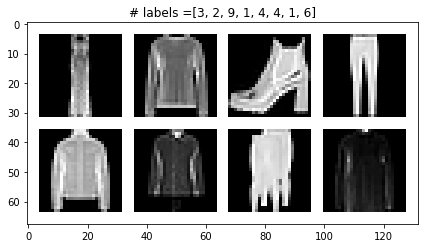

In [12]:
train_dataset.check()

Dataset lenght: 2000
imgs.shape torch.Size([8, 1, 28, 28])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


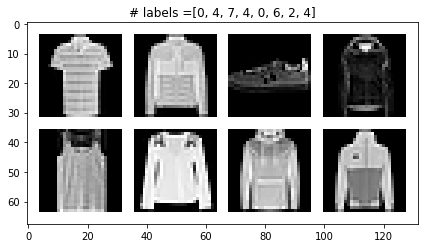

In [13]:
test_dataset.check()

### Instantiate model and optimizer

In [14]:
logging.info("Instantiate model and optimizer")
vae = VaeClass(params)
optimizer = instantiate_optimizer(vae, params)

luca_logging: Instantiate model and optimizer


### There are 3 possible simulation types: scratch, resumed, pretrained

In [15]:
logging.info("simulation type = "+str(params["simulation"]["type"]))

if (params["simulation"]["type"] == "scratch"):
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999

elif (params["simulation"]["type"] == "resumed"):
        
    resumed = load_info(path=params["simulation"]["path_to_file"], 
                        load_epoch=True, 
                        load_history=True)
    epoch_restart = resumed.epoch
    history_dict = resumed.history_dict
    min_test_loss = min(history_dict["test_loss"])
    
    load_model_optimizer(path=params["simulation"]["path_to_file"], 
                         model=vae,
                         optimizer=optimizer)

elif (params["simulation"]["type"] == "pretrained"):
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999
    
    load_model_optimizer(path=params["simulation"]["path_to_file"], 
                         model=vae,
                         optimizer=None)
    
# instantiate the scheduler if necessary    
if params["training"]["scheduler_is_active"]:
    scheduler = instantiate_scheduler(optimizer, params)

luca_logging: simulation type = scratch


### Train loop

In [ ]:
TEST_FREQUENCY = params["training"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["training"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["training"]["EPOCHS"]
BATCH_SIZE = params["training"]["batch_size"]

logging.info("start training -> "+datetime.now().strftime('%Y-%m-%d %H:%M:%S')) 
try:
    for delta_epoch in range(1,NUM_EPOCHS+1):
        epoch = delta_epoch+epoch_restart
        vae.train()   
        
        #with torch.autograd.set_detect_anomaly(True):
        with torch.autograd.set_detect_anomaly(False):
            train_metrics = train_one_epoch(vae, 
                                            train_dataset, 
                                            optimizer, 
                                            BATCH_SIZE, 
                                            verbose=False, 
                                            weight_clipper=None)
            s = pretty_print_metrics(epoch, train_metrics, is_train=True)
            logging.info(s)
                
            
            history_dict = add_named_tuple_to_dictionary(namedtuple=train_metrics, 
                                                         dictionary=history_dict,
                                                         key_prefix="train_")
            
        if params["training"]["scheduler_is_active"]:
            scheduler.step(epoch=epoch)
        
        if(epoch % TEST_FREQUENCY == 0):
            vae.eval()
            test_metrics = train_one_epoch(vae, 
                                           test_dataset, 
                                           optimizer, 
                                           BATCH_SIZE, 
                                           verbose=False, 
                                           weight_clipper=None)
            
            s = pretty_print_metrics(epoch, test_metrics, is_train=False)
            logging.info(s)
                    
            history_dict = add_named_tuple_to_dictionary(namedtuple=test_metrics, 
                                                         dictionary=history_dict,
                                                         key_prefix="test_")
            
            test_loss = test_metrics["loss"]
            min_test_loss = min(min_test_loss, test_loss)
                
            #if((test_loss == min_test_loss) or ((epoch % CHECKPOINT_FREQUENCY) == 0)): 
            if((test_loss == min_test_loss) or ((epoch % TEST_FREQUENCY) == 0)):
                checkpoint_file = os.path.join(output_dir, "ckp_"+str(epoch)+".pkl")
                history_file = os.path.join(output_dir, "history_"+str(epoch)+".pkl")
                
                save_everything(model=vae, 
                                optimizer=optimizer, 
                                history_dict=history_dict, 
                                epoch=epoch, 
                                params_dict=params, 
                                path=checkpoint_file)
                
                save_dict_as_json(history_dict, path=history_file)
                logging.info("saved files -> "+checkpoint_file+"  "+history_file)
                
    logging.info("end training -> "+datetime.now().strftime('%Y-%m-%d %H:%M:%S')) 

except KeyboardInterrupt:
    logging.info("Keyboard interrupt.  Terminated without saving.\n")

luca_logging: start training -> 2020-03-03 00:43:28


# Check the results

In [ ]:
history_dict.keys()

In [ ]:
for k,v in history_dict.items():
    print(k," -->", history_dict[k][-3:])

In [ ]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign=1

fontsize=10
fig, ax = plt.subplots(1,1)
ax.set_xlabel('REC',fontsize=fontsize)
ax.set_ylabel('REG',fontsize=fontsize)

ax.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), sign*np.array(history_dict["train_loss"])+y_shift,'-')
ax.plot(np.arange(x_shift, x_shift+len(history_dict["test_loss"])*TEST_FREQUENCY,TEST_FREQUENCY), sign*np.array(history_dict["test_loss"])+y_shift, '.--')
ax.set_xlabel('epoch')
ax.set_ylabel('LOSS = - ELBO')
ax.set_title('Training procedure')
ax.grid(True)
ax.legend(['train', 'test_clean', 'test_noisy'])

fig.tight_layout()
tmp_file = os.path.join(dir_output, "loss.png")
fig.savefig(tmp_file)

In [ ]:
# Plot of KL vs evidence
fontsize=20
labelsize=20

how_many = 2000
scale= 1
N = len(history_dict["train_kl"][-how_many :])
colors = np.arange(0.0,N,1.0)/N

fig, ax = plt.subplots(1,1)
#plt.yscale('log')
#plt.xlim(xmin=1.0, xmax=1.5)
ax.set_xlabel('REC',fontsize=fontsize)
ax.set_ylabel('REG',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.scatter(history_dict["train_nll"][-how_many :], history_dict["train_kl"][-how_many :],c=colors)
ax.plot(history_dict["train_nll"][-how_many :], history_dict["train_kl"][-how_many :], '-')
ax.grid()
#plt.xlim(xmax=2.5)

fig.tight_layout()
tmp_file = os.path.join(dir_output, "rec_kl_trajectory.png")
fig.savefig(tmp_file) 

### Check reconstruction

In [ ]:
tmp_list = [291, 413, 133, 148, 1,2,3,4,5,6,7,8,9]
reference_imgs, labels=test_dataset.load(batch_size=9, indices=tmp_list)
metric, inference = vae.reconstruct_img(reference_imgs)

reconstruction_file = os.path.join(output_dir, "imgs_reconstructed.png")
reference_file = os.path.join(output_dir, "imgs_reference.png")

imgs_ref = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")
imgs_ref.savefig(reference_file)

imgs_rec = show_batch(inference.reconstruction, n_col=3,n_padding=4, title="REC_IMG")
imgs_rec.savefig(reconstruction_file)

display(imgs_rec, imgs_ref)

# MAKE MOVIE

In [ ]:
epoch="xxx"
a = show_batch(inference.reconstruction[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
display(a)

# actual loop

In [ ]:
rec_filenames = []

for epoch in range(0,30,TEST_FREQUENCY):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    elif(epoch<10000):
        label = "_"+str(epoch)
    else:
        raise Exception

    try:
        checkpoint_file = os.path.join(output_dir, "ckp_"+str(epoch)+".pkl")
        _ = load_model_optimizer(path=checkpoint_file, model=vae, optimizer=None)
        metric, inference = vae.reconstruct_img(reference_imgs)
        tmp_fig = show_batch(inference.reconstruction[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        tmp_rec_file = os.path.join(output_dir, "imgs_rec"+label+".png")
        rec_filenames.append(tmp_rec_file)
        tmp_fig.savefig(tmp_rec_file, bbox_inches='tight') 
    except:
        pass

print(rec_filenames)

## Check individual images

In [ ]:
def show_frame_rec(n):
    tmp = Image(filename=rec_filenames[n])
    return display(tmp)

def show_frame_all(n):
    c = Image(filename=rec_filenames[n])
    return display(c)

# make gif file

In [ ]:
movie_rec_file_local = "movie_rec.gif"
movie_rec_file_absolute = os.path.join(output_dir, movie_rec_file_local)

frame_per_second = 2
im = mpy.ImageSequenceClip(rec_filenames, fps=frame_per_second)
im.write_gif(movie_rec_file_local, fps=frame_per_second)
im.write_gif(movie_rec_file_absolute, fps=frame_per_second)

In [ ]:
HTML("<img src="+movie_rec_file_local+"></img>")

In [ ]:
show_frame_rec(0)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")